================================================================
What this script does:
  • Loads UCI Bike Sharing "day.csv"
  • Restricts weathersit to values {1, 2, 3}
  • (b) OLS: cnt ~ weathersit (as categorical with baseline=1)
  • (c) Computes expected count difference between weathersit=1 and 3
  • (d) Reports RSS, R^2, and residual std. dev. for (b)
  • (e) OLS: cnt ~ weathersit + temp + hum + windspeed (+ interprets temp’s +10°C impact)
  • (f) Logistic Regression for High vs Low demand (> 4000), with train/test accuracy
  • (g) Chooses an alternative probability threshold (via max F1 on a validation split)
================================================================

-------------------------
Imports (with explanations)
-------------------------

Weathersit levels kept: [1, 2, 3]
    cnt weathersit      temp       hum  windspeed
0   985          2  0.344167  0.805833   0.160446
1   801          2  0.363478  0.696087   0.248539
2  1349          1  0.196364  0.437273   0.248309
3  1562          1  0.200000  0.590435   0.160296
4  1600          1  0.226957  0.436957   0.186900


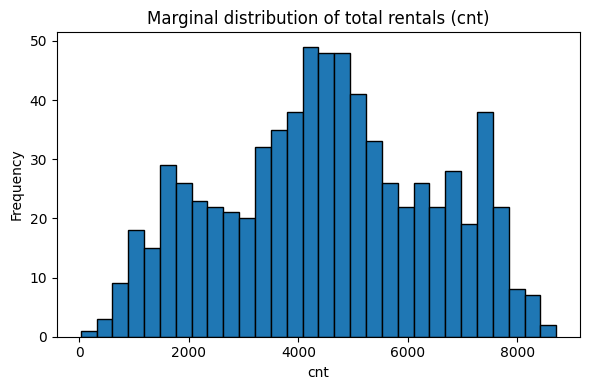

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# ------------------------------------------------------
# (0) Load and pre-process the dataset for this question
# ------------------------------------------------------
DATA_PATH = "data/day.csv"
df = pd.read_csv(DATA_PATH)
# Keep only the columns required by Q1 parts (b)–(g) to simplify analysis
df = df[["cnt", "weathersit", "temp", "hum", "windspeed"]].copy()
df = df[df["weathersit"].isin([1, 2, 3])].copy()  # Filter rows
df["weathersit"] = pd.Categorical(df["weathersit"], categories=[1, 2, 3])  # Fix category order (1 as baseline level)
print("Weathersit levels kept:", df["weathersit"].cat.categories.tolist())  # Sanity-check that only 1/2/3 remain
print(df.head())  # Peek at the first few rows to confirm structure
# ------------------------------------------------------
# (a) Marginal & conditional distributions (histogram + grouped boxplots + KDE overlays) ======
# ------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.hist(df["cnt"], bins=30, edgecolor="black")
plt.title("Marginal distribution of total rentals (cnt)")
plt.xlabel("cnt")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

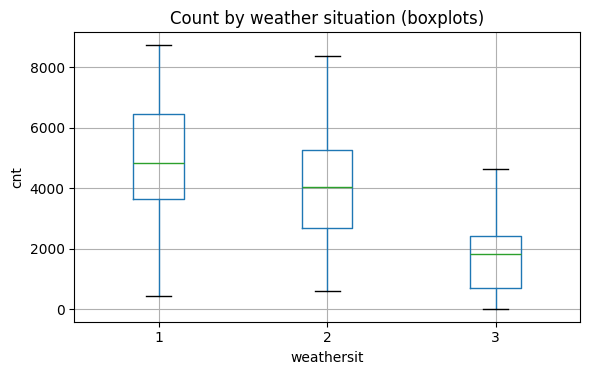

In [2]:
# ----- Conditional distribution of cnt by weather category (boxplots) -----
fig, ax = plt.subplots(figsize=(6, 4))
df.boxplot(column="cnt", by="weathersit", ax=ax)
ax.set_title("Count by weather situation (boxplots)")
ax.set_xlabel("weathersit")
ax.set_ylabel("cnt")
plt.suptitle("")
plt.tight_layout()
plt.show()

/var/folders/nw/cm9mnh314r948fx2f2wgq3xr0000gn/T/ipykernel_6344/2154472783.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ws, sub in df.groupby("weathersit"):


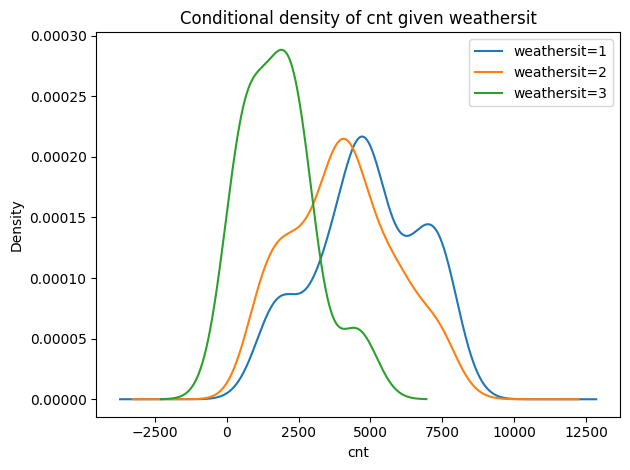

In [3]:
# ----- Overlay kernel density estimates (KDE) of cnt for each weather category -----
for ws, sub in df.groupby("weathersit"):
    sub["cnt"].plot(kind="kde", label=f"weathersit={ws}")
plt.title("Conditional density of cnt given weathersit")
plt.xlabel("cnt")
plt.legend()
plt.tight_layout()
plt.show()
# ----------------------------------------------------------
# (b) OLS: cnt ~ weathersit  (categorical, baseline=1)
# ----------------------------------------------------------
# Interpretation goal:
#   • Intercept = expected rentals when weathersit == 1 (baseline: Clear)
#   • Coefficient for weathersit=2 (and 3) = difference relative to baseline (1)
# Implementation detail:
#   • Using statsmodels formula with Treatment(reference=1) to fix the reference level explicitly

In [4]:
formula_b = "cnt ~ C(weathersit, Treatment(reference=1))"
model_b = smf.ols(formula=formula_b, data=df).fit()
print("\n=== (b) OLS: cnt ~ C(weathersit, reference=1) ===")  # Section header
print(model_b.summary())  # Full statistical summary (coefficients, standard errors, R^2, etc.)
coefs_b = model_b.params  # Extract the fitted coefficients into a Series for easy access
print("\n(b) Coefficients (interpretation in comments):")
print(coefs_b)
# Meaning:
#   • Intercept: E[cnt | weathersit=1]  (baseline expected rentals under Clear conditions)
#   • C(weathersit, Treatment(reference=1))[T.2]: E[cnt | weathersit=2] - E[cnt | weathersit=1]
#   • C(weathersit, Treatment(reference=1))[T.3]: E[cnt | weathersit=3] - E[cnt | weathersit=1]
#   → So, predicted E[cnt | weathersit=k] = Intercept + coefficient for level k (if k≠1)


=== (b) OLS: cnt ~ C(weathersit, reference=1) ===
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     40.07
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           3.11e-17
Time:                        12:22:37   Log-Likelihood:                -6531.5
No. Observations:                 731   AIC:                         1.307e+04
Df Residuals:                     728   BIC:                         1.308e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [5]:
# ----------------------------------------------------------
# (c) Expected difference between Clear (1) and Wet (3)
# ----------------------------------------------------------
# In this parameterization, the difference  E[cnt|3] - E[cnt|1]  equals the coefficient on weathersit=T.3
diff_1c = coefs_b.get("C(weathersit, Treatment(reference=1))[T.3]", np.nan)
print("\n=== (c) Expected difference (Clear=1 vs Wet=3) ===")
print(f"Diff = {diff_1c:.3f}")
# Interpretation:
#   • Positive value → wet (3) has higher expected rentals than clear (1) by this many bikes on average.
#   • Negative value → wet (3) has fewer expected rentals than clear (1) by |value| bikes on average.


=== (c) Expected difference (Clear=1 vs Wet=3) ===
Diff = -3073.500


In [6]:
# -------------------------------------------------------------------
# (d) Goodness-of-fit for model (b): RSS, R^2, residual std. deviation
# -------------------------------------------------------------------
resid = model_b.resid
RSS = float(np.sum(resid**2))
R2 = float(model_b.rsquared)
n = int(model_b.nobs)
p = int(len(model_b.params))
# Estimated residual standard deviation sqrt(RSS / (n - p))
sigma_hat = float(np.sqrt(RSS / (n - p)))
print("\n=== (d) Goodness-of-fit for (b) ===")
print(f"RSS={RSS:.3f}, R^2={R2:.4f}, sigma_hat={sigma_hat:.3f}")
# Interpretation:
#   • RSS smaller → better fit (all else equal).
#   • R^2 closer to 1 → more variance in cnt explained by weathersit levels.
#   • sigma_hat measures typical size of residuals in cnt units.


=== (d) Goodness-of-fit for (b) ===
RSS=2467890819.437, R^2=0.0992, sigma_hat=1841.184


In [7]:
# -------------------------------------------------------------------------------------
# (e) Multiple OLS: cnt ~ weathersit + temp + hum + windspeed  (+10°C impact explained)
# -------------------------------------------------------------------------------------
formula_e = "cnt ~ C(weathersit, Treatment(reference=1)) + temp + hum + windspeed"
model_e = smf.ols(formula=formula_e, data=df).fit()
print("\n=== (e) OLS: cnt ~ weathersit + temp + hum + windspeed ===")
print(model_e.summary())
# Extract coefficient on 'temp' to compute the effect of +10°C on expected rentals
beta_temp = model_e.params["temp"]
# Two interpretations for +10°C, depending on how 'temp' is stored.
#   1) If temp is normalized by 41°C to [0,1], then +10°C corresponds to +10/41 in model units.
#   2) If temp is already degrees Celsius, then +10°C is literally +10 in model units.
impact_10C_if_normalized = beta_temp * (10.0 / 41.0)
impact_10C_if_celsius = beta_temp * 10.0
print("(e) Coef(temp) =", f"{beta_temp:.3f}")
print("--> If 'temp' normalized by 41°C: +10°C impact ≈", f"{impact_10C_if_normalized:.2f}", "rentals")
print("--> If 'temp' already in °C:      +10°C impact ≈", f"{impact_10C_if_celsius:.2f}", "rentals")


=== (e) OLS: cnt ~ weathersit + temp + hum + windspeed ===
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     134.0
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          1.62e-100
Time:                        12:22:48   Log-Likelihood:                -6330.5
No. Observations:                 731   AIC:                         1.267e+04
Df Residuals:                     725   BIC:                         1.270e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [8]:
# ------------------------------------------------------------------------------------------------
# (f) Logistic Regression: classify demand as High (>4000) vs Low (≤4000), report accuracy metrics
# ------------------------------------------------------------------------------------------------
# Create a binary label for "High Demand": 1 if cnt > 4000, else 0
df["high_demand"] = (df["cnt"] > 4000).astype(int)
# Define features X and target y for classification
X = df[["weathersit", "temp", "hum", "windspeed"]]  # Include categorical and numeric weather variables
y = df["high_demand"]  # The binary target
# Split into train and test sets (25% test). Use stratify to preserve class balance across splits.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
# Identify categorical and numerical columns for preprocessing
cat_cols = ["weathersit"]
num_cols = ["temp", "hum", "windspeed"]
# Build OneHotEncoder kwargs in a version-compatible way:
#   • scikit-learn >= 1.2: OneHotEncoder(..., sparse_output=False)
#   • scikit-learn <  1.2: OneHotEncoder(..., sparse=False)
ohe_kwargs = {}
if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False
# ColumnTransformer applies one-hot to 'weathersit' (drop='first' sets baseline=1),
# and passes through numerical columns unchanged.
preproc = ColumnTransformer(
    transformers=[
        ("cat",
         OneHotEncoder(categories=[[1, 2, 3]], drop="first", **ohe_kwargs),
         cat_cols),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop"
)
# Define the logistic regression classifier
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
pipe = Pipeline(steps=[("pre", preproc), ("clf", clf)])
pipe.fit(X_train, y_train)
# Predict class labels on train and test sets using the default 0.5 probability threshold
train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)
# Compute accuracies
acc_train = accuracy_score(y_train, train_pred)
acc_test = accuracy_score(y_test, test_pred)
print("\n=== (f) Logistic Regression (>4000 => High) ===")
print(f"Accuracy - train: {acc_train:.3f}, test: {acc_test:.3f}")  # Report train/test accuracy
print("Confusion matrix (test):\n", confusion_matrix(y_test, test_pred))
print("Classification report (test):\n", classification_report(y_test, test_pred, digits=3))
# ---------------------------------------------------------------------------------------------------------
# (g) Choose a DIFFERENT decision threshold by maximizing F1 on a validation split, then compare on test set
# ---------------------------------------------------------------------------------------------------------
# First, split the training set again into (tr2, val) for threshold selection
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train
)
pipe.fit(X_tr, y_tr)
val_proba = pipe.predict_proba(X_val)[:, 1]  # Probability of class 1 (High Demand)
# Define a grid of candidate thresholds to scan (from 0.1 to 0.9 by 0.01)
thresholds = np.linspace(0.1, 0.9, 81)
def f1_at(y_true, prob, t):
    # Convert probabilities to hard labels using threshold t
    yhat = (prob >= t).astype(int)
    # Compute F1 score for the positive class (1)
    return f1_score(y_true, yhat)
f1s = np.array([f1_at(y_val, val_proba, t) for t in thresholds])
# Pick the threshold that maximizes validation F1
best_t = float(thresholds[int(np.argmax(f1s))])
best_f1_val = float(np.max(f1s))
# Now evaluate BOTH: (i) the chosen best_t and (ii) the default 0.5 on the TEST set
test_proba = pipe.predict_proba(X_test)[:, 1]          # Probabilities on test set
test_pred_new = (test_proba >= best_t).astype(int)     # Hard labels with chosen threshold
test_pred_base = (test_proba >= 0.5).astype(int)       # Hard labels with default threshold
# Compute accuracy and F1 for both thresholds
acc_test_new = accuracy_score(y_test, test_pred_new)
f1_test_new = f1_score(y_test, test_pred_new)
acc_test_base = accuracy_score(y_test, test_pred_base)
f1_test_base = f1_score(y_test, test_pred_base)


=== (f) Logistic Regression (>4000 => High) ===
Accuracy - train: 0.832, test: 0.803
Confusion matrix (test):
 [[51 19]
 [17 96]]
Classification report (test):
               precision    recall  f1-score   support

           0      0.750     0.729     0.739        70
           1      0.835     0.850     0.842       113

    accuracy                          0.803       183
   macro avg      0.792     0.789     0.791       183
weighted avg      0.802     0.803     0.803       183



In [9]:
print("\n=== (g) Threshold selection by max F1 on validation ===")
print(f"Best threshold t* (val): {best_t:.3f}, F1_val={best_f1_val:.3f}")
print(f"Test with t*:  Accuracy={acc_test_new:.3f}, F1={f1_test_new:.3f}")
print(f"Test with 0.5: Accuracy={acc_test_base:.3f}, F1={f1_test_base:.3f}")
# Interpretation:
#   • If F1(t*) > F1(0.5) on TEST, the chosen threshold improved the precision/recall tradeoff for the positive class.
#   • If not, the threshold tuned on validation did not generalize as well (common due to sampling noise,
#     class imbalance, or imperfect probability calibration).


=== (g) Threshold selection by max F1 on validation ===
Best threshold t* (val): 0.460, F1_val=0.870
Test with t*:  Accuracy=0.814, F1=0.856
Test with 0.5: Accuracy=0.809, F1=0.847
